In [1]:
import json
import numpy as np

In [2]:
with open("five_letter_words.json", "r") as words_read:
	words = json.load(words_read)

In [3]:
import string

letter_dict = dict((a, i) for i, a in enumerate(string.ascii_lowercase))

In [4]:
encoded_words = []

for w in words:
	encoded_words.append([letter_dict[l] for l in w])

In [5]:
encoded_words_numpy = np.array(encoded_words)

In [6]:
encoded_words_numpy

array([[ 0,  0,  7,  4,  3],
       [ 0,  0, 11,  8,  8],
       [ 0,  0, 17,  6,  7],
       ...,
       [25, 14, 17,  8, 18],
       [25, 14, 22,  8,  4],
       [25, 24, 12,  4, 18]])

In [9]:
def to_onehot(encoded):
	onehot = np.zeros([i for i in encoded.shape] + [len(string.ascii_lowercase)]).reshape(-1, len(string.ascii_lowercase))

	onehot[np.arange(0, onehot.shape[0]), encoded.reshape(-1,)] = 1.

	return onehot.reshape([i for i in encoded.shape] + [len(string.ascii_lowercase)])


In [10]:
onehot_words = to_onehot(encoded_words_numpy)

In [12]:
onehot_words.shape

(8548, 5, 26)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
letter_dist = onehot_words.mean(axis = 0)

letter_dist.shape

(5, 26)

In [47]:
letter_dist[0].sum()

1.0

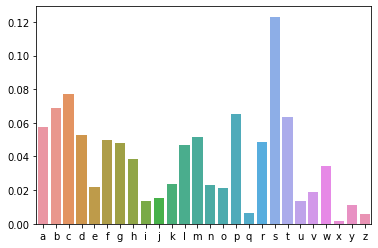

In [46]:
sns.barplot(x = np.arange(0, len(string.ascii_lowercase)), y = letter_dist[0])
plt.xticks(ticks = np.arange(0, len(string.ascii_lowercase)), labels = [l for l in string.ascii_lowercase])
pass

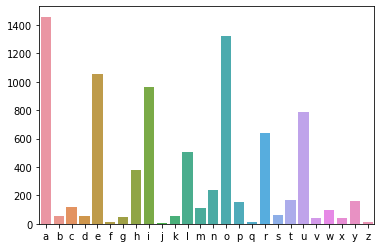

In [29]:
sns.barplot(x = np.arange(0, len(string.ascii_lowercase)), y = letter_dist[1])
plt.xticks(ticks = np.arange(0, len(string.ascii_lowercase)), labels = [l for l in string.ascii_lowercase])
pass

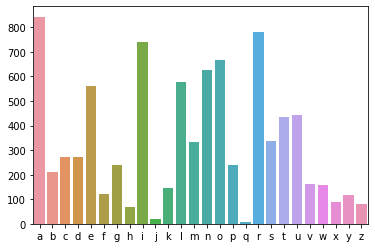

In [30]:
sns.barplot(x = np.arange(0, len(string.ascii_lowercase)), y = letter_dist[2])
plt.xticks(ticks = np.arange(0, len(string.ascii_lowercase)), labels = [l for l in string.ascii_lowercase])
pass

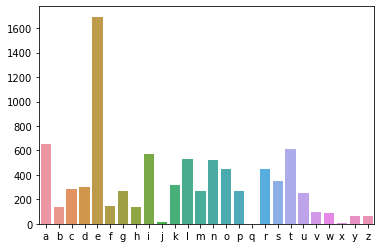

In [33]:
sns.barplot(x = np.arange(0, len(string.ascii_lowercase)), y = letter_dist[3])
plt.xticks(ticks = np.arange(0, len(string.ascii_lowercase)), labels = [l for l in string.ascii_lowercase])
pass

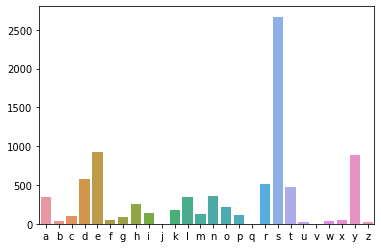

In [32]:
sns.barplot(x = np.arange(0, len(string.ascii_lowercase)), y = letter_dist[4])
plt.xticks(ticks = np.arange(0, len(string.ascii_lowercase)), labels = [l for l in string.ascii_lowercase])
pass

Process:
- greedy guess from vocab distribution (most probable at each position)
- adjust guess to word that loses the least information based on information-sum list
- advance state with word
- given a (5, 26) tensor
	- 5: each position in word
	- 26: each letter in position
	- each coordinate is either 3 (correct position), 2 (in word and could be here), 1 (not in this position), or 0 (not guessed)
- use tensor to filter possible words
- create new vocab distribution
- calculate new word information matrix (5, 26)
	- each cell representing the probability of a letter in that position
- apply word info matrix in all available vocab to create newest information-sum list

In [48]:
def get_vocab_distribution(vocab):
	return vocab.mean(axis = 0)

In [57]:
def word_information(vocab, vocab_distribution, state):
	
	info_list = []

	for v in vocab:
		info_list.append(information_gained(v, vocab_distribution, state))
	
	return info_list


In [1]:
def information_gained(w, vocab_distribution, state):
	# w: (5, 26) word
	
	total_info = 0.0

	for i in range(w.shape[0]):
		# Probability of new information gained

		l = np.argmax(w[i])

		if state[i, l] in [1,3]:
			continue

		if state[i, l] == 2:
			total_info +=  (vocab_distribution[i, l] * 3.) + (1. - vocab_distribution[i, l])

		total_info += (vocab_distribution[i, l] * 3.) + (vocab_distribution[np.arange(0, w.shape[0]) != i, l].mean() * 2.) + (1. - vocab_distribution[:, l].mean())
	
	return (w, total_info)


In [55]:
def update_state(state, letter_info):
	l = letter_dict[letter_info[1]]
	position = letter_info[0]
	
	if letter_info[1] == 1:
		state[:, l] = 1.

	if letter_info[1] == 2:
		state[:, l] = 2.
		state[position, l] = 1.

	if letter_info[1] == 3:
		state[position, :] = 1.
		state[position, l] = 3.
	
	return state



In [56]:
def get_state(guesses):
	new_state = np.zeros((5, 26))
	all_update_guesses = []
	for g in guesses:
		for i, l in enumerate(g):
			all_update_guesses.append((i, l[0], l[1]))

	for info in sorted(all_update_guesses, key = lambda x: x[2]):
		new_state = update_state(new_state, info)
	
	return new_state

In [40]:
a = np.array([0,1,1,1,0])
b = np.array([0, 2, 0, 0, 1])

In [35]:
a == 1

array([False,  True,  True,  True, False])

In [42]:
b.astype("bool")

array([False,  True, False, False,  True])

In [39]:
(b == 1).sum()

2

In [38]:
a.any()

True

In [52]:
def vocab_filter_cycle(vocab, condition, p, l):
	v = np.argmax(vocab, axis = -1)

	if condition == 1:
		return vocab[v[:, p] != l]
	if condition == 3:
		return vocab[v[:, p] == l]
	
	return vocab

In [53]:
def vocab_filter_total(state, vocab):
	for p in range(state.shape[0]):
		for l in range(state.shape[1]):
			vocab = vocab_filter_cycle(vocab, state[p, l], p, l)
	return vocab

In [49]:
if -1:
	print('1')

1


In [ ]:
def full_process(guesses, vocab):
	state = get_state(guesses)
	new_vocab = vocab_filter_total(state, vocab)
	

In [ ]:
def full_process(guesses, vocab):
	state = get_state(guesses)
	new_vocab = vocab_filter_total(state, vocab)
	vocab_dist = get_vocab_distribution(new_vocab)
	info_list = word_information(new_vocab, vocab_dist, state)
	new_guess = max(info_list, key = lambda x: x[1])
	print(new_guess)
	return new_guess